In [ ]:
from google.colab import drive
drive.mount('/content/drive')


import os

import torch
os.chdir('/content/drive/MyDrive/ImitationLearning/Invariant-Causal-Imitation-Learning-main/')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# load

In [ ]:
!pip install mpi4py 
!pip install box2d-py
!pip install box2d 
!pip3 install gym[Box_2D] 
!pip install gym==0.17.2 -qqq
!pip install numpy~=1.18.2 -qqq
!pip install pandas~=1.0.4 -qqq
!pip install PyYAML~=5.4.1 -qqq
!pip install scikit-learn~=0.22.2 -qqq
!pip install scipy~=1.1.0 -qqq
!pip install stable-baselines~=2.10.1 -qqq
!pip install tensorflow~=1.15.0 -qqq
!pip install torch>=1.6.0 -qqq
!pip install tqdm~=4.32.1 -qqq


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
sh

#config

In [ ]:

config = {
    "ENV": "CartPole-v1",
    "ALG": "BCIRMStudent_Apr17",
    "NUM_TRAJS_GIVEN": 20, #
    "NUM_TRAINING_ENVS": 2,
    "NOISE_DIM": 4,
    "REP_SIZE": 16,
    "TRAJ_SHIFT": 20, # 20,
    "SAMPLING_RATE": 5,
    "NUM_STEPS_TRAIN": 10000,
    "NUM_TRAJS_VALID": 100,
    "NUM_REPETITIONS": 15,
    "BATCH_SIZE": 64,
    "MLP_WIDTHS": 64,
    "ADAM_ALPHA": 1e-3,
    "SGLD_BUFFER_SIZE": 10000,
    "SGLD_LEARN_RATE": 0.01,
    "SGLD_NOISE_COEF": 0.01,
    "SGLD_NUM_STEPS": 100,
    "SGLD_REINIT_FREQ": 0.05,
    "NUM_STEPS_TRAIN_ENERGY_MODEL": 1000,
    #"NUM_STEPS_TRAIN_VAE_MODEL": 20000,
    'TRIAL': 0
}


#config['ENV'] = "LunarLander-v2"
config['ENV'] = "CartPole-v1"

#config['METHOD'] = "BCIRM"
config['METHOD'] = "iVAE_IRM"
#config['METHOD'] = 'iVAE_2steps'




if config['METHOD'] == 'BCIRM':
    config['l2_regularizer_weight'] = 0.001
    config['penalty_weight'] = 10000
    config['penalty_anneal_iters'] = 2500
elif config['METHOD'] == "iVAE_IRM":
    config["NUM_STEPS_TRAIN_VAE_MODEL"] = 500 # phase1
    config["NUM_STEPS_TRAIN"] = 10000 # phase 3
    config['PHASE2_SAMPLES'] = 10000 # phase 2
    config['l2_regularizer_weight'] = 0.00
    config['penalty_weight'] = 0 #10
    config['BATCH_SIZE'] = 1024
    config['MODEL_TYPE'] = 'NFiVAE'





#testing/il

In [ ]:
import argparse
import os
import pickle

import gym
import numpy as np
import pandas as pd
import yaml
import numpy as np

from testing.paths import get_model_path, get_trajs_path  # pylint: disable=reimported

from contrib.energy_model import EnergyModel
from contrib.env_wrapper import EnvWrapper, get_test_mult_factors
from network import EnvDiscriminator
from network import FeaturesDecoder
from network import FeaturesEncoder
from network import MineNetwork 
from network import ObservationsDecoder
from network import StudentNetwork, StudentNetwork_2hidden


from student import ICILStudent, BCStudent, BCIRMStudent, iVAE_IRMStudent 
from testing.train_utils import fill_buffer, make_agent, save_results
from vae.ivae_wrapper import VAE_wrapper
  
from torch import nn

# make student

In [ ]:
"""
#self.causal_features_encoder.parameters
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

get_n_params(self.causal_features_encoder) + get_n_params(self.policy_network)
"""

In [ ]:


# pylint: disable=redefined-outer-name
def make_student(run_seed, config):
    env = gym.make(config["ENV"])
    trajs_path = get_trajs_path(config["ENV"], "student_" + config["ALG"], env_id="student", run_seed=run_seed)
    model_path = get_model_path(config["ENV"], "student_" + config["ALG"], run_seed=run_seed)

    state_dim = env.observation_space.shape[0] + config["NOISE_DIM"]
    action_dim = env.action_space.n
    num_training_envs = config["NUM_TRAINING_ENVS"]

    # run_seed = run_seed
    batch_size = config["BATCH_SIZE"]
    teacher = make_agent(config["ENV"], config["EXPERT_ALG"], config["NUM_TRAINING_ENVS"])
    teacher.load_pretrained()

    buffer = fill_buffer(
        trajs_path=teacher.trajs_paths,
        batch_size=batch_size,
        run_seed=run_seed,
        traj_shift=config["TRAJ_SHIFT"],
        buffer_size_in_trajs=config["NUM_TRAJS_GIVEN"],
        sampling_rate=config["SAMPLING_RATE"],
    )

    if buffer.total_size < batch_size:
        batch_size = buffer.total_size



    ##########################      COMMON      ##########################

    print("state_dim", state_dim)

    causal_features_encoder = FeaturesEncoder(
        input_size=state_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"]
    )

    policy_network = StudentNetwork(in_dim=config["REP_SIZE"], out_dim=action_dim, width=config["MLP_WIDTHS"])

    #print("config method = ", config['METHOD'])


    ##########################       BC       #######################

    if config['METHOD'] == 'BC':

        #causal_features_encoder = FeaturesEncoder(
        #    input_size=state_dim-4, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"]
        #)

        return BCStudent(
            env=env,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            causal_features_encoder=causal_features_encoder,
            policy_network=policy_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )


    ##########################       BC IRM       #######################


    elif config['METHOD'] == 'BCIRM':

        return BCIRMStudent(
            env=env,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            causal_features_encoder=causal_features_encoder,
            policy_network=policy_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )



    ##########################       iVAE IRM       #######################

    elif config['METHOD'] == 'iVAE_IRM':

        config['LATENT_DIM'] = state_dim - 3  # latent dim for iVAE, not causal-feature-encoder and policy-network

        print("latent dim = ", config['LATENT_DIM'] )

        vae_wrapper =  VAE_wrapper(buffer, data_dim = state_dim, action_dim = action_dim, env_dim = config['NUM_TRAINING_ENVS'], latent_dim = config['LATENT_DIM'], 
                                   use_e = True, model_type= config['MODEL_TYPE'])
        #vae_wrapper =  VAE_wrapper(buffer, data_dim = state_dim, action_dim = action_dim, env_dim = config['NUM_TRAINING_ENVS'], latent_dim = 8, use_e = True)
        
        loss_list = vae_wrapper.train(num_updates=config["NUM_STEPS_TRAIN_VAE_MODEL"])

        import matplotlib.pyplot as plt
        plt.plot(np.log(np.array(loss_list)))
        plt.show()


        #vae_wrapper.start_phase2(n_samples = config['PHASE2_SAMPLES'])
        vae_wrapper.pa_list = [0,1,2,3,4,5,6,7] #, 8, 9, 10, 11]
        

        #causal_features_encoder = FeaturesEncoder(
        #    input_size=config["LATENT_DIM"], representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"] )

        #policy_network = StudentNetwork_2hidden(in_dim=config["REP_SIZE"], out_dim=action_dim, width=config["MLP_WIDTHS"])
        policy_network = StudentNetwork(in_dim=config["LATENT_DIM"], out_dim=action_dim, width=config["MLP_WIDTHS"])
        


        # pylint: disable=redefined-builtin
        class CausalFeaturesEncoder(nn.Module):
            def __init__(self, input_size, representation_size, width):
                super().__init__()

                self.layers = nn.Sequential(
                    nn.Linear(input_size, 32),
                    nn.ELU(),
                    nn.Linear(32, 64),
                    nn.ELU(),
                    nn.Linear(64, 96),
                    nn.ELU(),
                    nn.Linear(96,  32),
                    nn.ELU(),          
                    nn.Linear(32, representation_size),
                )

            def forward(self, x):
                return self.layers(x)



        phase3_obs_to_latent_encoder = CausalFeaturesEncoder(
            input_size=state_dim, representation_size=config["LATENT_DIM"], width=config["MLP_WIDTHS"] )
        
        #causal_features_encoder = FeaturesEncoder(
        #            input_size=state_dim, representation_size = len(vae_wrapper.pa_list), width=config["MLP_WIDTHS"])

        #policy_network = StudentNetwork(in_dim = config['LATENT_DIM'], out_dim=action_dim, width=config["MLP_WIDTHS"])

        
        return iVAE_IRMStudent(
            env=env,
            vae_wrapper = vae_wrapper,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            phase3_obs_to_latent_encoder = phase3_obs_to_latent_encoder,
            causal_features_encoder=causal_features_encoder,
            policy_network=policy_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )
        


    ##########################       ICIL        #######################

    elif config['METHOD'] == 'ICIL':
        energy_model = EnergyModel(
            in_dim=state_dim,
            width=config["MLP_WIDTHS"],
            batch_size=batch_size,
            adam_alpha=config["ADAM_ALPHA"],
            buffer=buffer,
            sgld_buffer_size=config["SGLD_BUFFER_SIZE"],
            sgld_learn_rate=config["SGLD_LEARN_RATE"],
            sgld_noise_coef=config["SGLD_NOISE_COEF"],
            sgld_num_steps=config["SGLD_NUM_STEPS"],
            sgld_reinit_freq=config["SGLD_REINIT_FREQ"],
        )
        energy_model.train(num_updates=config["NUM_STEPS_TRAIN_ENERGY_MODEL"])

        causal_features_decoder = FeaturesDecoder(action_size=action_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"])

        observations_decoder = ObservationsDecoder(representation_size=config["REP_SIZE"], out_size=state_dim, width=config["MLP_WIDTHS"] )

        env_discriminator = EnvDiscriminator(representation_size=config["REP_SIZE"], num_envs=config["NUM_TRAINING_ENVS"], width=config["MLP_WIDTHS"])

        noise_features_encoders = [FeaturesEncoder(input_size=state_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"])  
            for i in range(num_training_envs)]
        
        noise_features_decoders = [FeaturesDecoder(action_size=action_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"])
            for i in range(num_training_envs)]

        mine_network = MineNetwork(x_dim=config["REP_SIZE"], z_dim=config["REP_SIZE"], width=config["MLP_WIDTHS"])

        return ICILStudent(
            env=env,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            causal_features_encoder=causal_features_encoder,
            noise_features_encoders=noise_features_encoders,
            causal_features_decoder=causal_features_decoder,
            noise_features_decoders=noise_features_decoders,
            observations_decoder=observations_decoder,
            env_discriminator=env_discriminator,
            policy_network=policy_network,
            energy_model=energy_model,
            mine_network=mine_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )


def init_arg():
    parser = argparse.ArgumentParser()
    parser.add_argument("--env_name", default="CartPole-v1")
    parser.add_argument("--num_trajectories", default=20, type=int)
    parser.add_argument("--trial", default=0, type=int)
    return parser.parse_args()


#10 Trails -- BC

In [ ]:
config['METHOD'] = "BC"

for traj_num in [20]:
    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "test6_BCStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "BCStudent_Apr19_replicatedata"
    #config['METHOD'] = "BC"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"
    #config["NUM_TRAJS_GIVEN"] = 20
    #config["TRAJ_SHIFT"] = 20
    ###############.  settings   ###############



    if config['METHOD'] == 'BCIRM':
        config['l2_regularizer_weight'] = 0.001
        config['penalty_weight'] = 10000
        config['penalty_anneal_iters'] = 100

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))
            student = make_student(run_seed, config)
            student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1
            )
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample
            )

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

Config: {'ENV': 'CartPole-v1', 'ALG': 'test6_BCStudent_replicatedata_trajnum20', 'NUM_TRAJS_GIVEN': 20, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 20, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 15, 'BATCH_SIZE': 64, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'METHOD': 'BC', 'NUM_STEPS_TRAIN_VAE_MODEL': 10000, 'PHASE2_SAMPLES': 50000, 'EXPERT_ALG': 'dqn'}
Trial number 0
config method =  BC
config env =  CartPole-v1
Run 1 out of 15
state_dim 8
epoch 9000/10000, policy loss 0.42501622438430786	epoch 0/100 return: 500.0


KeyboardInterrupt: ignored

In [ ]:
torch.stack(student.loss_list).mean()

tensor(0.4000, device='cuda:0')

In [ ]:
torch.stack(student.loss_list).std()

tensor(0.0725, device='cuda:0')

#10 Trails -- iVAE IRM

# BC

In [ ]:
self = student 
sampled_states, sampled_latents, sampled_actions = self.vae_wrapper.phase2_sampled_data(100000)

In [ ]:
def stored_x_z_pairs():

    all_states = []
    all_actions = []
    all_envs = []

    trajs_paths = []
    for env_id in range(self.config["NUM_TRAINING_ENVS"]):
        path = get_trajs_path(self.config["ENV"], "expert", env_id)
        trajs_paths.append(path)

    for path in trajs_paths:
        #pairs_env = []
        #try:
        #    trajs = np.load(path, allow_pickle=True)["trajs"]
        #except:
        trajs = np.load(path, allow_pickle=True)[()]["trajs"]

        for traj in trajs:
            for i in range(len(traj)-1):
                all_states.append(traj[i][0])
                all_actions.append(traj[i][1])
                all_envs.append(traj[i][2])

                #pairs_env.append((traj[i][0], traj[i][1], traj[i + 1][0], traj[i][2]))

        #all_pairs += pairs_env

    x = torch.FloatTensor(all_states).to(self.device)

    a = F.one_hot(torch.LongTensor(all_actions), num_classes = self.vae_wrapper.action_dim)#.to(self.device)
          

    if self.vae_wrapper.use_a and self.vae_wrapper.use_e:
        #print("predict latent using both a and e")
        e = F.one_hot(torch.LongTensor(all_envs), num_classes = self.vae_wrapper.env_dim)#.to(self.device)
        ae = torch.cat((a, e), 1).to(torch.float32).to(self.device)
    elif self.vae_wrapper.use_e == False:
        #print("predict latent using only a")
        ae = a.to(torch.float32).to(self.device)

    _, _, z, _ = self.vae_wrapper.model(x, ae)


    return x.detach().cpu().numpy(), z.detach().cpu().numpy()



def find_matched_z(x, dim_list = None):
    if dim_list == None:
        dim_list = np.arange(self.vae_wrapper.state_dim).tolist()
    return self.stored_z[np.argmin(np.linalg.norm(x[dim_list] - self.stored_x[:, dim_list], axis = 1))]

In [ ]:
stored_x, stored_z = stored_x_z_pairs()

In [ ]:
np.arange(self.vae_wrapper.state_dim).tolist()

[0, 1, 2, 3, 4, 5, 6, 7]

In [ ]:
stored_z[np.argmin(np.linalg.norm(env.reset() - stored_x, axis = 1))]

array([ 0.10336317,  0.85937274,  1.420731  ,  0.06224243,  0.31721923,
       -0.12666115, -1.4303365 ,  0.21197322], dtype=float32)

In [ ]:
z.shape

torch.Size([499000, 8])

In [ ]:
(all_pairs[0])

(array([-0.04456399,  0.04816344,  0.01265734, -0.02152644,  0.04653909,
         0.01326909, -0.02099827,  0.        ]),
 1,
 array([-0.04363321,  0.24039529,  0.01371454, -0.31176683,  0.24146827,
         0.01284913, -0.30946529,  0.        ]),
 0)

In [ ]:
#action = torch.LongTensor(samples["action"]).to(self.device)
#env_ids = torch.LongTensor(samples["env"]).to(self.device)
samples = self.buffer.sample()
self.vae_wrapper.predict_latent(samples).detach().shape

torch.Size([64, 4])

In [ ]:
import torch.optim as optim
import torch.nn as nn
import copy
from torch import autograd

self = student

self.config['l2_regularizer_weight'] = 0.00
self.config['penalty_anneal_iters'] = 5000
self.config['penalty_weight'] = 10000

loss_list = []
total_loss_list = []

config["NUM_TRAJS_GIVEN"] = 20
buffer = fill_buffer(
    trajs_path=self.teacher.trajs_paths,
    batch_size=64,
    run_seed=run_seed,
    traj_shift=config["TRAJ_SHIFT"],
    buffer_size_in_trajs=config["NUM_TRAJS_GIVEN"],
    sampling_rate=config["SAMPLING_RATE"],
)

self.buffer = buffer

self.config = config 

num_updates = 10000



policy_network = StudentNetwork(in_dim=8, out_dim=self.vae_wrapper.action_dim, width=config["MLP_WIDTHS"])
#policy_network = StudentNetwork_2hidden(in_dim=4, out_dim=self.vae_wrapper.action_dim, width=config["MLP_WIDTHS"])

#causal_features_encoder = FeaturesEncoder(input_size=self.vae_wrapper.state_dim, representation_size=self.vae_wrapper.state_dim*4, width=config["MLP_WIDTHS"])

self.num_training_envs = 2

#self.causal_features_encoder = causal_features_encoder.to(self.device)
self.policy_network = policy_network.to(self.device)

#self.adam_alpha = adam_alpha

#self.policy_opt = optim.Adam(
#   list(causal_features_encoder.parameters()) + list(policy_network.parameters()), lr=self.adam_alpha
#)

self.policy_opt = optim.Adam(
     list(self.policy_network.parameters()), lr=self.adam_alpha)

#self.buffer = buffer

self.config = config


#self.vae_wrapper.use_e = True



def serialize():
    torch.save(self.policy_network.state_dict(), self.model_path)

def deserialize():
    self.policy_network.load_state_dict(torch.load(self.model_path))

def _update_networks():
    samples = self.buffer.sample()

    ce_loss, loss = _compute_loss(samples)

    #policy_loss = ce_loss 
    policy_loss = loss 
    
    self.policy_opt.zero_grad()
    policy_loss.backward()
    self.policy_opt.step()
    
    loss_list.append(ce_loss)
    total_loss_list.append(loss)
    return ce_loss, policy_loss

    
def _compute_loss(samples):
    state = torch.FloatTensor(samples["state"]).to(self.device)
    #state = state[:,:-4]
    #samples['state'] = samples['state'][:,:-4]

    action = torch.LongTensor(samples["action"]).to(self.device)
    env_ids = torch.LongTensor(samples["env"]).to(self.device)

    latents = self.vae_wrapper.predict_latent(samples).detach()
    masked_latents = copy.deepcopy(latents)
    if len(self.masked_states)>0:
        masked_latents[:, self.masked_states] = 0

    #causal_rep = self.causal_features_encoder(masked_latents)  # need this encoder: S -> rep
    #print("mask latents shape", masked_latents.shape)
    # 1. Policy loss
    #qvalues = self.policy_network(causal_rep) # need this encoder:  rep -> A
    qvalues = self.policy_network(masked_latents) # need this encoder:  rep -> A
    #print("qvalues shape", qvalues.shape)


    ce_loss_env = []
    penalty_env = []
    for idx in range(self.num_training_envs):
        env_idx = torch.where(env_ids==idx)[0]
        env_state = state[env_idx]
        env_action = action[env_idx]
        env_qvalues = qvalues[env_idx]
        
        ce_loss_env.append(_cross_entropy_loss(env_qvalues, env_action) * len(env_idx))
        penalty_env.append(_penalty(env_qvalues, env_action) * len(env_idx))
    
    ce_loss = torch.stack(ce_loss_env).sum() / len(env_ids)
    penalty = torch.stack(penalty_env).sum() / len(env_ids)
    
    #ce_loss = self._cross_entropy_loss(qvalues, action)
    #penalty = self._penalty(qvalues, action)
    
    weight_norm = torch.tensor(0.).cuda()
    #for w in self.causal_features_encoder.parameters():
    #    weight_norm += w.norm().pow(2)
    for w in self.policy_network.parameters():
        weight_norm += w.norm().pow(2)
        
        
    loss = ce_loss.clone()
    #loss += self.config['l2_regularizer_weight'] * weight_norm
    penalty_weight =  5 #(self.config['penalty_weight'] if self.curr_update >= self.config['penalty_anneal_iters'] else 1.0)
    


    #loss += penalty_weight * penalty

    if penalty_weight > 1.0:
    # Rescale the entire loss to keep gradients in a reasonable range
        loss /= 1 #penalty_weight




    #ce_loss = nn.CrossEntropyLoss()(qvalues, action)

    return ce_loss, loss


  
def _cross_entropy_loss(qvalues, action):
    return nn.CrossEntropyLoss()(qvalues, action)


def _penalty(qvalues, action):
    """
    input: 
        logits: qvalues
        y: actions
    """
    scale = torch.tensor(1.).cuda().requires_grad_()
    loss = _cross_entropy_loss(qvalues * scale, action)
    grad = autograd.grad(loss, [scale], create_graph=True)[0]
    return torch.sum(grad**2)        

    


def train(num_updates):


    for update_index in (range(num_updates)):
        self.curr_update = update_index
        #print("here")
        ce_loss, policy_loss = _update_networks()
        if update_index % 1000 == 0:
            #print(update_index)
            #print(update_index)
            print('\repoch {}/{}, ce loss {}, policy loss {}\t'.format(update_index, num_updates, ce_loss, policy_loss.detach() ), end="")
            
    #env.close()

    #erialize()




In [ ]:
train(num_updates=config["NUM_STEPS_TRAIN"]*3)

epoch 29000/30000, ce loss 0.44969984889030457, policy loss 0.44969984889030457	

tensor(0.4513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0693, device='cuda:0', grad_fn=<StdBackward0>)


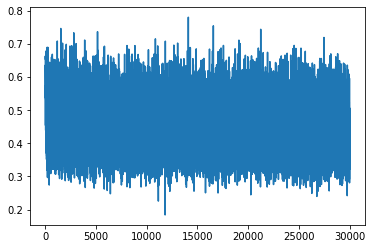

In [ ]:

try:
    loss_list = (torch.stack(loss_list))
except:
    pass
print(loss_list.mean(), loss_list.std())
import matplotlib.pyplot as plt
plt.plot(loss_list.tolist())

In [ ]:
import torch.nn as nn
import copy

self = student 
samples = self.buffer.sample()

policy_network = StudentNetwork(in_dim=self.vae_wrapper.state_dim, out_dim=self.vae_wrapper.action_dim, width=config["MLP_WIDTHS"])
self.policy_network = policy_network.to(self.device)

state = torch.FloatTensor(samples["state"]).to(self.device)
action = torch.LongTensor(samples["action"]).to(self.device)

latents = self.vae_wrapper.predict_latent(samples).detach()

# phase 3. obs_to_latent  MSE loss
obs_to_latent_rep = self.phase3_obs_to_latent_encoder(state)
mse_loss = nn.MSELoss()(obs_to_latent_rep, latents)


# phase 1. policy loss
masked_latents = copy.deepcopy(latents)
#if len(self.masked_states)>0:
#    masked_latents[:, self.masked_states] = 0

#causal_rep = self.causal_features_encoder(masked_latents)  # need this encoder: S -> rep
#qvalues = self.policy_network(causal_rep) # need this encoder:  rep -> A
qvalues = self.policy_network(latents) # need this encoder:  rep -> A

ce_loss = nn.CrossEntropyLoss()(qvalues, action)


policy_loss = ce_loss 
self.policy_opt.zero_grad()
policy_loss.backward()
self.policy_opt.step()


obs_to_latent_loss = mse_loss
self.obs_to_latent_opt.zero_grad()
obs_to_latent_loss.backward()
self.obs_to_latent_opt.step()
        

In [ ]:
config['METHOD'] = "iVAE_IRM"

#for traj_num in [1, 2, 4, 8, 16, 32, 64, 100]:
if True:
    traj_num = 20

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "FINAL_ivaeIRMStudent_replicatedata73_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** train student *****")
            student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

batch size =  2
Config: {'ENV': 'CartPole-v1', 'ALG': 'FINAL_ivaeIRMStudent_replicatedata73_trajnum20', 'NUM_TRAJS_GIVEN': 20, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 20, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 15, 'BATCH_SIZE': 2, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 20000, 'PHASE2_SAMPLES': 10000, 'l2_regularizer_weight': 0.0, 'penalty_weight': 0, 'EXPERT_ALG': 'dqn'}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 1 out of 15

***** make student *****
state_dim 8
latent dim =  16
use both actions and env as aux variables
epoch 19900/20000 	loss: -4.2824249267578125
***** generated stored data *****
generating stored samples using both a and e

***** train st

KeyboardInterrupt: ignored

batch size =  1024
Config: {'ENV': 'CartPole-v1', 'ALG': 'FINAL_ivaeIRMStudent_replicatedata83_trajnum20', 'NUM_TRAJS_GIVEN': 20, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 20, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 15, 'BATCH_SIZE': 1024, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 500, 'PHASE2_SAMPLES': 10000, 'l2_regularizer_weight': 0.0, 'penalty_weight': 0, 'MODEL_TYPE': 'NFiVAE', 'EXPERT_ALG': 'dqn'}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 1 out of 15

***** make student *****
state_dim 8
latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

epoch 400/500 	loss: 17.63547134399414

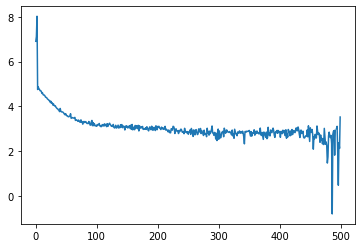


***** generated stored data *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/student/vae_irm_student.py:396: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  x = torch.FloatTensor(all_states).to(self.device)


generating stored samples using both a and e

***** train student *****
epoch 9000/10000, policy loss 1.6204583630496927e-07	
***** test student *****
epoch 0/100 return: 15.0
epoch 1/100 return: 14.0
epoch 2/100 return: 16.0
epoch 3/100 return: 12.0
epoch 4/100 return: 18.0
epoch 5/100 return: 18.0
epoch 6/100 return: 18.0
epoch 7/100 return: 14.0
epoch 8/100 return: 17.0
epoch 9/100 return: 19.0
epoch 10/100 return: 17.0
epoch 11/100 return: 15.0
epoch 12/100 return: 16.0
epoch 13/100 return: 19.0
epoch 14/100 return: 13.0
epoch 15/100 return: 14.0
epoch 16/100 return: 18.0
epoch 17/100 return: 15.0
epoch 18/100 return: 18.0
epoch 19/100 return: 19.0
epoch 20/100 return: 13.0
epoch 21/100 return: 15.0
epoch 22/100 return: 16.0
epoch 23/100 return: 16.0
epoch 24/100 return: 15.0
epoch 25/100 return: 14.0
epoch 26/100 return: 15.0
epoch 27/100 return: 13.0
epoch 28/100 return: 13.0
epoch 29/100 return: 13.0
epoch 30/100 return: 19.0
epoch 31/100 return: 13.0
epoch 32/100 return: 16.0
e

KeyboardInterrupt: ignored

In [ ]:
config['METHOD'] = "iVAE_IRM"

#for traj_num in [1, 2, 4, 8, 16, 32, 64, 100]:
if True:
    traj_num = 20

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "FINAL_ivaeIRMStudent_replicatedata83_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** train student *****")
            student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
student.masked_states

[]

In [ ]:
student.config['dim_list']

In [ ]:
student.stored_z.shape

(499000, 5)

In [ ]:

# pylint: disable=redefined-builtin
class phase3_obs_to_latent_encoder(nn.Module):
    def __init__(self, obs_size, latent_size):
        super().__init__()

        self.layers = nn.Sequential(
            #nn.Linear(obs_size, 128),
            nn.Linear(obs_size, 32),
            nn.ELU(),
            nn.Linear(32, 64),
            nn.ELU(),
            #nn.Linear(64, 96),
            #nn.ELU(),
            nn.Linear(64,  32),
            nn.ELU(),          
            nn.Linear(32, latent_size),
        )

    def forward(self, x):
        return self.layers(x)


In [1]:
self = student 
phase3_encoder = phase3_obs_to_latent_encoder(student.vae_wrapper.state_dim, student.vae_wrapper.latent_dim).to(self.device)
phase3_optimizer = torch.optim.Adam(phase3_encoder.parameters(), lr=0.01)

from tqdm import tqdm
import random 

phase3_bs = 1024
phase3_epochs = 1000
total_idxs = list(range(len(student.stored_z)))
n_batch = len(student.stored_z) // phase3_bs + 1
phase3_loss_list = []
for epoch in tqdm(range(phase3_epochs)):
    random.shuffle(total_idxs)
    phase3_epoch_loss = 0
    for j in range(n_batch):
        batch_idxs = total_idxs[j * phase3_bs : (j + 1) * phase3_bs]
        batch_x = torch.as_tensor(student.stored_x[batch_idxs], device=self.device)#.long()
        batch_z = torch.as_tensor(student.stored_z[batch_idxs], device=self.device)#.long()
        
        phase3_optimizer.zero_grad() 
        z_pred = phase3_encoder(batch_x)
        phase3_loss =  nn.L1Loss()(z_pred, batch_z)
        phase3_loss.backward() 
        phase3_optimizer.step() 
        phase3_epoch_loss += phase3_loss.detach().cpu().item()
        #accuracy = (batch_act == logits.argmax(1)).float().mean()
    print(epoch, phase3_epoch_loss)


NameError: ignored

In [ ]:
batch_x

tensor([[-8.2277e-02, -1.4657e-01, -4.9051e-02,  ..., -5.2143e-01,
         -7.5074e-01,  1.0000e+00],
        [-9.2247e-01,  3.1353e-02, -1.3045e-03,  ..., -1.3743e-03,
          1.2704e-01,  0.0000e+00],
        [-6.0414e-01, -5.4880e-01,  3.4925e-02,  ...,  3.4183e-02,
          1.7159e-01,  0.0000e+00],
        ...,
        [-1.2332e+00,  1.9350e-01, -1.0043e-02,  ..., -9.9297e-02,
         -3.6140e-01,  1.0000e+00],
        [-8.2848e-01,  3.5474e-01, -1.1809e-04,  ..., -1.3150e-01,
         -6.1514e-01,  1.0000e+00],
        [-8.6948e-01, -1.4646e-01,  6.4692e-03,  ...,  7.3306e-03,
         -7.8140e-03,  0.0000e+00]], device='cuda:0')

In [ ]:

env_wrapper_out_of_sample = EnvWrapper(
    env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)


state = self.env.reset()
state_env = env_wrapper_out_of_sample._get_obs(state)



In [ ]:
phase3_encoder.forward(torch.FloatTensor(state_env).to(self.device))

tensor([-0.6589, -0.1689, -1.5054, -0.1814,  0.1097], device='cuda:0',
       grad_fn=<AddBackward0>)

In [ ]:
student.phase3_obs_to_latent_encoder = phase3_encoder

In [ ]:
print("\n***** test student *****")
action_match, return_mean, return_std = student.test(
    num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)



***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 return: 500.0
epoch 35/100 return: 500.0
epoch 36/100